In [1]:
from random import random, choices, randint, seed
from collections import Counter
from scipy.stats import binom
from statistics import mean,stdev
import matplotlib.pyplot as plt
from numpy import sqrt,power
from copy import deepcopy

In [2]:
#org and genome classes

class Genome:
    def __init__(self,sites,genomeLength):
        if sites is None:
            self.sites = self.initSites(genomeLength)
            self.length = genomeLength
        else:
            self.sites = sites
            self.length = len(sites)
          
        
    def initSites(self,genomeLength):
        # all zeroes; good for sawtooth or max-1
        return [0 for _ in range(genomeLength)]

    
    
class Organism:
    def __init__(self,genome,genomeLength):
        if genome is None:
            self.genome = Genome(None,genomeLength)
        else:
            self.genome = genome
        self.offspringCount = 0
        self.fitness = None
            
    
    def makeMutatedCopy(self,):
        global MU
        self.offspringCount += 1
        
        newOrganism = Organism(deepcopy(self.genome),self.genome.length)
        for i in range(newOrganism.genome.length):
            if random() <= MU:
                sign = 1 if random() <= 0.5 else -1
                newOrganism.genome.sites[i] += sign
        return newOrganism
    
    
    def getFitness(self,evalFunc):
        if self.fitness is None:
            self.fitness = evalFunc(self)
        return self.fitness

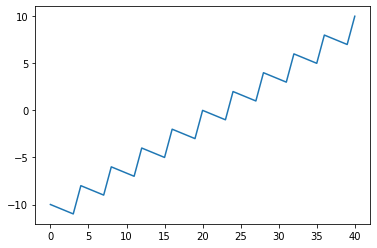

In [3]:
#fitness function and selection algorithms
def sawtooth(organism,plot=False):
    w = 3 #valley width
    d = 1 #valley depth
    r = 2 #fitness rise peak to peak
    
    if plot:
        anon = lambda v: v*(-d/w) + (v//(w+1))*(r + d + (d/w))
        plt.plot([anon(v) for v in range(-20,21)])
        plt.show()
        return
    
    x = sum(organism.genome.sites)
    x = x + w+1 #offset to next peak to avoid fitness zero on init
    
    return x*(-d/w) + (x//(w+1))*(r + d + (d/w))

sawtooth(None,plot=True)

def constFitness(organism):
    return 1

def linearFitness(organism):
    return (2/5)*sum(organism.genome.sites)

def tournament(population,size=2):
    global EVAL_FUNC
    return max(choices(population,k=size),key=lambda org: org.getFitness(EVAL_FUNC))

def roulette_select(population,batchSize,exp=1.05):
    global POP_SIZE, EVAL_FUNC
    MAX = max([org.getFitness(EVAL_FUNC) for org in population])
    F = [ power(exp,org.getFitness(EVAL_FUNC)-MAX) for org in population]
    S = sum(F)
    return choices(list(range(POP_SIZE)),k=batchSize,weights=[f/S for f in F])

def onePeak(organism):
    x = sum(organism.genome.sites)
#     return -(sum(organism.genome.sites)**2)
    return 2*x if x < 0 else -0.5*x

In [4]:
#selection strength components
DR = {}
def getDriftReference(initialPop,finalPop):
    key = (initialPop,finalPop)
    if key not in DR:
        DR[key] = [binom.pmf(x, finalPop, 1/initialPop) for x in range(finalPop+1)]
    return DR[key]

MDR = {}
def moranDriftReference(N):
    if N not in MDR:
        z = (N-1)/(2*N-1)
        gtr1 = lambda n: (N/(N-1))**2 * (z)**(n+1)
        MDR[N] = [z if n==0 else gtr1(n) for n in range(N+1)]
    return MDR[N]


def emd(P,Q):
    assert len(P) == len(Q)
    EMD = [0]
    for i in range(len(P)):
        EMD.append(P[i]-Q[i]+EMD[-1])
    return sum([abs(d) for d in EMD])


def getSS(offCounts_1d,initialPop,finalPop):
    Counts = Counter(offCounts_1d)
    Observed = [Counts[x]/initialPop if x in Counts else 0 for x in range(finalPop+1)]
    return emd(getDriftReference(initialPop,finalPop),Observed)


def getSSMoran(offCounts_1d,N):
    Counts = Counter(offCounts_1d)
    Observed = [Counts[x]/N if x in Counts else 0 for x in range(N+1)]
    return emd(moranDriftReference(N),Observed)


def dictionaryReduce(listOfDict,target={}):
    for dic in listOfDict:
        for key in set(list(dic.keys())+list(target.keys())):
            if key not in target:
                target[key] = []
            target[key].append(dic[key])
    return target

In [5]:
#parameters
seed(1337)

POP_SIZE = 1000
GENOME_LENGTH = 1
MU = 1.0/(2.5*(GENOME_LENGTH))
print("mu",MU)
GENERATIONS = 250
TSIZE = 3
REXP = 10

EVAL_FUNC = sawtooth
# EVAL_FUNC = constFitness
# EVAL_FUNC = linearFitness

BIRTH = 1
BIRTHNUM = 1
DEATH = 1

mu 0.4


In [7]:
# basic MORAN theory confirmation

population = [Organism(None,GENOME_LENGTH) for _ in range(POP_SIZE)]
aveFitLog = []
maxFitLog = []
deathLog = []
popSizeLog = []

for update in range(GENERATIONS*POP_SIZE):
    print( (100*update)/(GENERATIONS*POP_SIZE)  ,"%",end="\r")
    aveFitness = mean([org.getFitness(EVAL_FUNC) for org in population])
    aveFitLog.append(aveFitness)
    maxFitness = max([org.getFitness(EVAL_FUNC) for org in population])
    maxFitLog.append(maxFitness)
#     popSizeLog.append(len(population))
#     print(int( (100*update)/(GENERATIONS*POP_SIZE) ), popSizeLog[-1])
    
    #michael model
#     child = []
#     if random() <= BIRTH:
#         for _ in range(BIRTHNUM):
#             child.append(tournament(population,size=TSIZE).makeMutatedCopy())
    
#     death = []
#     for i in range(len(population)):
#         if random() <= DEATH:
#             deathLog.append(deepcopy(population[i]))
#             death.append(i)
    
    #standard model
    child = []
    if random() <= BIRTH:
#         child.append(tournament(population,size=TSIZE).makeMutatedCopy())
        child.append(population[roulette_select(population,1,exp=REXP)[0]].makeMutatedCopy())
    
    death = []
    if random() <= DEATH:
        deathID = randint(0,POP_SIZE-1)
        deathLog.append(deepcopy(population[deathID]))
        death.append(deathID)
    
    population = [org for i,org in enumerate(population) if i not in death] + child
print()


99.9996 %% %%


In [ ]:
# plt.figure(figsize=(10,5))
# plt.plot(popSizeLog)
# plt.show()

In [ ]:
#plot moran results


WINDOW = POP_SIZE #generation size for SS
POINTS = GENERATIONS*POP_SIZE / WINDOW

win = 10 #average window size (2w+1)

start = 2*WINDOW
stop = len(aveFitLog)

plt.figure(figsize=(10,5))
plt.plot(aveFitLog[start:stop])
plt.plot(maxFitLog[start:stop])
plt.show()


selStrLog = []
offCountAcc = {}
for i in range(int(POINTS)):
    deathGen = deathLog[i*WINDOW:(i+1)*WINDOW]
    offspringCounts = Counter([org.offspringCount for org in deathGen])
    selectionStrength = getSSMoran(offspringCounts,WINDOW)
    selStrLog.append(selectionStrength)
    offCountAcc = dictionaryReduce([offspringCounts],target=offCountAcc)

print(len(selStrLog),POINTS)
print(range(start//WINDOW,stop//WINDOW))
AVEDATA = [mean(selStrLog[max(start//WINDOW,i-win):min(i+win+1,stop//WINDOW)]) for i in range(start//WINDOW,stop//WINDOW)] # CORRECTED
print(mean(selStrLog),stdev(selStrLog))

plt.figure(figsize=(10,5))
plt.plot(range(start//WINDOW,stop//WINDOW),selStrLog[start//WINDOW:stop//WINDOW],color="k")
plt.plot(range(start//WINDOW,stop//WINDOW),AVEDATA,color="r",linewidth="2")
# plt.yscale("log")
plt.show()

threshold = 0
prob = 1
tempDR = moranDriftReference(WINDOW)
while prob > 0.05:
    prob -= tempDR[threshold]
    threshold += 1
print("organisms geq", threshold,"are sig. more than expected (5%)")

PValSelStrLog = []
for i in range(int(POINTS)):
    deathGen = deathLog[i*WINDOW:(i+1)*WINDOW]
    offspringCounts = Counter([org.offspringCount for org in deathGen])
    selectionStrength = sum([v for k,v in offspringCounts.items() if k >= threshold])
    PValSelStrLog.append(selectionStrength/WINDOW)
PAVEDATA = [mean(PValSelStrLog[max(start//WINDOW,i-win):min(i+win+1,stop//WINDOW)]) for i in range(start//WINDOW,stop//WINDOW)] # CORRECTED
plt.figure(figsize=(10,5))
plt.plot(range(start//WINDOW,stop//WINDOW),PValSelStrLog[start//WINDOW:stop//WINDOW],color="k")
plt.plot(range(start//WINDOW,stop//WINDOW),PAVEDATA,color="r",linewidth="2")
# plt.yscale("log")
plt.show()

plt.scatter(selStrLog[start//WINDOW:stop//WINDOW],PValSelStrLog[start//WINDOW:stop//WINDOW],color="k")
plt.scatter(AVEDATA,PAVEDATA,color="r")
plt.show()
    
# meanDict = {k: mean(V)/WINDOW for k,V in offCountAcc.items()}
# stdvDict = {k: stdev(V)/WINDOW for k,V in offCountAcc.items()}

# plt.figure(figsize=(10,5))
# plt.plot(moranDriftReference(WINDOW)[:max(offCountAcc.keys())+1],
#          label="Moran Drift Theory",color="k")

# plt.scatter(meanDict.keys(),meanDict.values(),label="(Mean Count)/(Pop. Size)",color="r")

# plt.fill_between(sorted(stdvDict.keys()),
#                  [meanDict[k]+(2.58*stdvDict[k])/sqrt(POINTS) for k in sorted(stdvDict.keys())],
#                  [meanDict[k]-(2.58*stdvDict[k])/sqrt(POINTS) for k in sorted(stdvDict.keys())],
#                  alpha=0.3,color="r",label="99% Confidence interval")
# plt.legend()
# plt.title("")
# plt.xlabel("Parent's Offspring Count")
# plt.ylabel("Fraction of Parents with Count")
# plt.yscale("log")
# plt.show()


fig, axs = plt.subplots(2,1,figsize=(12,8))
axs[0].plot(list(range(start,stop)),aveFitLog[start:stop],label="Average Fitness")
axs[0].plot(list(range(start,stop)),maxFitLog[start:stop],label="Max Fitness")
axs[0].set_xlabel("Updates")
axs[0].set_ylabel("Fitness Function Score")
axs[0].legend()
axs[1].plot(list(range(start//WINDOW,stop//WINDOW)),selStrLog[start//WINDOW:stop//WINDOW],color="k",label="Selection Strength")
axs[1].plot(list(range(start//WINDOW,stop//WINDOW)),AVEDATA,linewidth=2,color="r",label="Traveling Average")
axs[1].set_xlabel("Generations")
axs[1].set_ylabel("EMD($f_D$,$f$)")
# axs[1].legend()
plt.show()